In [82]:
import numpy as np 
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
import math
from IPython.display import display, Markdown
import scipy.stats as stats

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Decide between local or kaggle cloud storage         
KAGGLE_ENV = 'kaggle' in os.listdir('/')
data_path = '/kaggle/input' if KAGGLE_ENV else '../kaggle/input'
    
    
for dirname, _, filenames in os.walk(data_path):
    for filename in filenames:
        print(os.path.join(dirname, filename)) 
        
competition_name = '/playground-series-s5e3'
target_feature = 'rainfall'
# area under the ROC curve 

../kaggle/input/rainfall-prediction-using-machine-learning/Rainfall.csv
../kaggle/input/playground-series-s5e3/sample_submission.csv
../kaggle/input/playground-series-s5e3/test.csv
../kaggle/input/playground-series-s5e3/train.csv


In [83]:
def merge_rare_categories(df, feature, threshold):
    value_counts = df[feature].value_counts()

    to_remove = value_counts[value_counts < threshold].index
    print(to_remove)

    # Replace the data cell with NaN
    df[feature] = df[feature].apply(lambda x: x if x not in to_remove else None)

    print(df.head(25))
    return df

In [84]:
def cramers_v(x, y):
    confusion_matrix = pd.crosstab(x, y)
    chi2 = stats.chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    phi2 = chi2 / n
    r, k = confusion_matrix.shape
    phi2corr = max(0, phi2 - ((k-1)*(r-1))/(n-1))
    rcorr = r - ((r-1)**2)/(n-1)
    kcorr = k - ((k-1)**2)/(n-1)
    return np.sqrt(phi2corr / min((kcorr-1), (rcorr-1)))

In [85]:
def plot_heatmap(df, feature, target):
    # Absolute values calculation (number of cases per feature and target)
    degree_dep_table = pd.crosstab(df[feature], df[target])

    # Check if target has only two categories (e.g., binary classification)
    if len(degree_dep_table.columns) == 2:
        # Sort rows by the number of cases where target = 1 (depression cases)
        degree_dep_table = degree_dep_table.sort_values(by=1, ascending=False)

    # Relative values calculation (row-wise normalization to get percentage values)
    degree_dep_table_rel = degree_dep_table.div(degree_dep_table.sum(axis=1), axis=0) * 100

    # Ensure that the sorting is applied to both tables
    degree_dep_table_rel = degree_dep_table_rel.loc[degree_dep_table.index]

    # Combined display: Absolute values + percentage values in one cell
    combined_table = degree_dep_table.astype(str) + " (" + degree_dep_table_rel.round(2).astype(str) + "%)"

    # Plot heatmap
    plt.figure(figsize=(35, 12))
    sns.heatmap(degree_dep_table_rel, annot=combined_table, fmt="", cmap="coolwarm")
    plt.title(f"{target} Distribution by {feature} (Sorted by Highest {target} Cases)")
    plt.show()

# Intoduction

In this exploratory data analysis (EDA), we aim to gain a deeper understanding of the dataset by performing the following key steps:

- Understand the structure of the data: Identify data types, feature distributions, and basic statistics.
- Explore patterns and relationships: Examine correlations, feature interactions, and potential trends.
- Detect missing values: Identify incomplete data and evaluate possible imputation strategies.
- Identify outliers: Locate extreme values that may impact model performance or require transformation.

This analysis will provide valuable insights to guide further data preprocessing and modeling decisions.

# Load Data

In [86]:
# Load the data s
train_original = pd.read_csv(data_path + competition_name + '/train.csv')
test_original = pd.read_csv(data_path + competition_name + '/test.csv')
sample_submission = pd.read_csv(data_path + competition_name+ '/sample_submission.csv')
original_data = pd.read_csv(data_path  + '/rainfall-prediction-using-machine-learning/Rainfall.csv')

# Quick Overview

In [87]:
train_original.tail(100)

,id,day,pressure,maxtemp,temparature,mintemp,dewpoint,humidity,cloud,sunshine,winddirection,windspeed,rainfall
2090,2090,266,1018.9,31.0,28.7,26.6,24.8,85.0,53.0,4.5,220.0,14.7,0
2091,2091,267,1008.8,27.5,25.4,24.9,23.2,92.0,95.0,0.0,40.0,25.1,1
2092,2092,268,1013.7,29.2,25.3,23.1,20.7,77.0,19.0,9.5,20.0,10.3,0
2093,2093,269,1015.4,31.8,28.0,26.4,24.7,79.0,72.0,7.8,210.0,20.2,0
2094,2094,270,1016.8,31.2,28.7,27.0,23.1,77.0,47.0,8.5,70.0,25.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2185,2185,361,1014.6,23.2,20.6,19.1,19.9,97.0,88.0,0.1,40.0,22.1,1
2186,2186,362,1012.4,17.2,17.3,16.3,15.3,91.0,88.0,0.0,50.0,35.3,1
2187,2187,363,1013.3,19.0,16.3,14.3,12.6,79.0,79.0,5.0,40.0,32.9,1
2188,2188,364,1022.3,16.4,15.2,13.8,14.7,92.0,93.0,0.1,40.0,18.0,1


In [88]:
test_original.head()

,id,day,pressure,maxtemp,temparature,mintemp,dewpoint,humidity,cloud,sunshine,winddirection,windspeed
0,2190,1,1019.5,17.5,15.8,12.7,14.9,96.0,99.0,0.0,50.0,24.3
1,2191,2,1016.5,17.5,16.5,15.8,15.1,97.0,99.0,0.0,50.0,35.3
2,2192,3,1023.9,11.2,10.4,9.4,8.9,86.0,96.0,0.0,40.0,16.9
3,2193,4,1022.9,20.6,17.3,15.2,9.5,75.0,45.0,7.1,20.0,50.6
4,2194,5,1022.2,16.1,13.8,6.4,4.3,68.0,49.0,9.2,20.0,19.4


In [89]:
original_data.head()

,day,pressure,maxtemp,temparature,mintemp,dewpoint,humidity,cloud,rainfall,sunshine,winddirection,windspeed
0,1,1025.9,19.9,18.3,16.8,13.1,72,49,yes,9.3,80.0,26.3
1,2,1022.0,21.7,18.9,17.2,15.6,81,83,yes,0.6,50.0,15.3
2,3,1019.7,20.3,19.3,18.0,18.4,95,91,yes,0.0,40.0,14.2
3,4,1018.9,22.3,20.6,19.1,18.8,90,88,yes,1.0,50.0,16.9
4,5,1015.9,21.3,20.7,20.2,19.9,95,81,yes,0.0,40.0,13.7


In [90]:
sample_submission.head(100)

,id,rainfall
0,2190,0
1,2191,0
2,2192,0
3,2193,0
4,2194,0
...,...,...
95,2285,0
96,2286,0
97,2287,0
98,2288,0


In [91]:
original_data.head()

,day,pressure,maxtemp,temparature,mintemp,dewpoint,humidity,cloud,rainfall,sunshine,winddirection,windspeed
0,1,1025.9,19.9,18.3,16.8,13.1,72,49,yes,9.3,80.0,26.3
1,2,1022.0,21.7,18.9,17.2,15.6,81,83,yes,0.6,50.0,15.3
2,3,1019.7,20.3,19.3,18.0,18.4,95,91,yes,0.0,40.0,14.2
3,4,1018.9,22.3,20.6,19.1,18.8,90,88,yes,1.0,50.0,16.9
4,5,1015.9,21.3,20.7,20.2,19.9,95,81,yes,0.0,40.0,13.7


# Overview

In [92]:
def data_overview(data, target):
    # Overview
    display(Markdown("## Data Overview"))
    
    display(Markdown("### General Information"))
    display(Markdown(f"- Number of rows and columns: {data.shape[0]} x {data.shape[1]}"))
    display(Markdown("- Column names:"))
    display(list(data.columns))

    display(Markdown("### Data Types & Missing Values"))
    missing = data.isnull().sum()
    dtypes = pd.DataFrame(data.dtypes, columns=["Data Type"])
    missing_df = pd.DataFrame(missing, columns=["Missing Values"])
    overview_df = dtypes.join(missing_df)
    display(overview_df.style.background_gradient(cmap="coolwarm"))

    display(Markdown("### Classic head of Data"))
    display(data.head().style.set_properties(**{"background-color": "#f5f5f5"}))

    display(Markdown("### Statistical Summary (describe)"))
    display(data.describe().T.style.background_gradient(cmap="viridis"))

    # Target variable analysis
    if target is not None:
        display(Markdown(f"## Target Variable: `{target}`"))
        sns.set_style("whitegrid")  
        sns.set_palette("viridis")   

        fig, ax = plt.subplots(1, 2, figsize=(14, 5))

        #   Absolute frequency barplot
        sns.barplot(x=data[target].value_counts().index, 
                y=data[target].value_counts(), 
                ax=ax[0])  

        ax[0].set_title("Absolute Frequency", fontsize=12, fontweight="bold")
        ax[0].set_ylabel("Count")
        ax[0].set_xlabel(target)
        ax[0].grid(axis="y", linestyle="--", alpha=0.5)  

        # Percentage distribution barplot
        sns.barplot(x=data[target].value_counts().index, 
                    y=data[target].value_counts(normalize=True), 
                    ax=ax[1])  

        ax[1].set_title("Percentage Distribution", fontsize=12, fontweight="bold")
        ax[1].set_ylabel("Percentage")
        ax[1].set_xlabel(target)
        ax[1].grid(axis="y", linestyle="--", alpha=0.5)

    

        for spine in ["top", "right"]:
            ax[0].spines[spine].set_visible(False)
            ax[1].spines[spine].set_visible(False)

    plt.tight_layout()
    plt.show()

## Data Overview

### General Information

- Number of rows and columns: 366 x 12

- Column names:

['day',
 'pressure ',
 'maxtemp',
 'temparature',
 'mintemp',
 'dewpoint',
 'humidity ',
 'cloud ',
 'rainfall',
 'sunshine',
 '         winddirection',
 'windspeed']

### Data Types & Missing Values

,Data Type,Missing Values
day,int64,0
pressure,float64,0
maxtemp,float64,0
temparature,float64,0
mintemp,float64,0
dewpoint,float64,0
humidity,int64,0
cloud,int64,0
rainfall,object,0
sunshine,float64,0


### Classic head of Data

,day,pressure,maxtemp,temparature,mintemp,dewpoint,humidity,cloud,rainfall,sunshine,winddirection,windspeed
0,1,1025.900000,19.900000,18.300000,16.800000,13.100000,72,49,yes,9.300000,80.000000,26.300000
1,2,1022.000000,21.700000,18.900000,17.200000,15.600000,81,83,yes,0.600000,50.000000,15.300000
2,3,1019.700000,20.300000,19.300000,18.000000,18.400000,95,91,yes,0.000000,40.000000,14.200000
3,4,1018.900000,22.300000,20.600000,19.100000,18.800000,90,88,yes,1.000000,50.000000,16.900000
4,5,1015.900000,21.300000,20.700000,20.200000,19.900000,95,81,yes,0.000000,40.000000,13.700000


### Statistical Summary (describe)

,count,mean,std,min,25%,50%,75%,max
day,366.000000,15.756831,8.823592,1.000000,8.000000,16.000000,23.000000,31.000000
pressure,366.000000,1013.742623,6.414776,998.500000,1008.500000,1013.000000,1018.100000,1034.600000
maxtemp,366.000000,26.191257,5.978343,7.100000,21.200000,27.750000,31.200000,36.300000
temparature,366.000000,23.747268,5.632813,4.900000,18.825000,25.450000,28.600000,32.400000
mintemp,366.000000,21.894536,5.594153,3.100000,17.125000,23.700000,26.575000,30.000000
dewpoint,366.000000,19.989071,5.997021,-0.400000,16.125000,21.950000,25.000000,26.700000
humidity,366.000000,80.177596,10.062470,36.000000,75.000000,80.500000,87.000000,98.000000
cloud,366.000000,71.128415,21.798012,0.000000,58.000000,80.000000,88.000000,100.000000
sunshine,366.000000,4.419399,3.934398,0.000000,0.500000,3.500000,8.200000,12.100000
winddirection,365.000000,101.506849,81.723724,10.000000,40.000000,70.000000,190.000000,350.000000


## Target Variable: `rainfall`

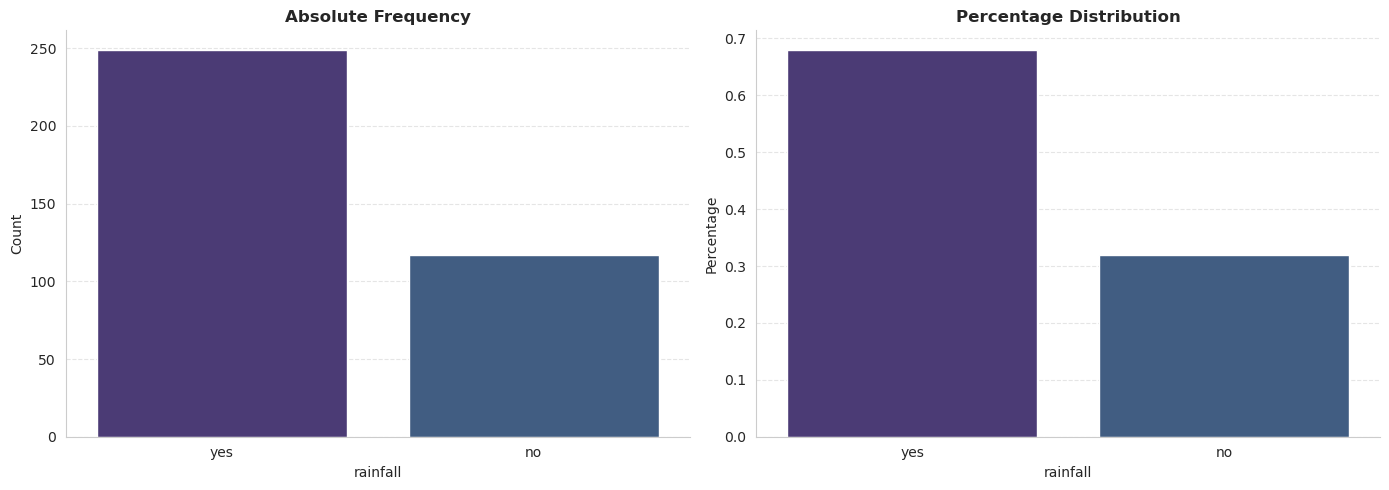

In [93]:
data_overview(original_data, target_feature)

## Data Overview

### General Information

- Number of rows and columns: 2190 x 13

- Column names:

['id',
 'day',
 'pressure',
 'maxtemp',
 'temparature',
 'mintemp',
 'dewpoint',
 'humidity',
 'cloud',
 'sunshine',
 'winddirection',
 'windspeed',
 'rainfall']

### Data Types & Missing Values

,Data Type,Missing Values
id,int64,0
day,int64,0
pressure,float64,0
maxtemp,float64,0
temparature,float64,0
mintemp,float64,0
dewpoint,float64,0
humidity,float64,0
cloud,float64,0
sunshine,float64,0


### Classic head of Data

,id,day,pressure,maxtemp,temparature,mintemp,dewpoint,humidity,cloud,sunshine,winddirection,windspeed,rainfall
0,0,1,1017.400000,21.200000,20.600000,19.900000,19.400000,87.000000,88.000000,1.100000,60.000000,17.200000,1
1,1,2,1019.500000,16.200000,16.900000,15.800000,15.400000,95.000000,91.000000,0.000000,50.000000,21.900000,1
2,2,3,1024.100000,19.400000,16.100000,14.600000,9.300000,75.000000,47.000000,8.300000,70.000000,18.100000,1
3,3,4,1013.400000,18.100000,17.800000,16.900000,16.800000,95.000000,95.000000,0.000000,60.000000,35.600000,1
4,4,5,1021.800000,21.300000,18.400000,15.200000,9.600000,52.000000,45.000000,3.600000,40.000000,24.800000,0


### Statistical Summary (describe)

,count,mean,std,min,25%,50%,75%,max
id,2190.000000,1094.500000,632.342866,0.000000,547.250000,1094.500000,1641.750000,2189.000000
day,2190.000000,179.948402,105.203592,1.000000,89.000000,178.500000,270.000000,365.000000
pressure,2190.000000,1013.602146,5.655366,999.000000,1008.600000,1013.000000,1017.775000,1034.600000
maxtemp,2190.000000,26.365799,5.654330,10.400000,21.300000,27.800000,31.200000,36.000000
temparature,2190.000000,23.953059,5.222410,7.400000,19.300000,25.500000,28.400000,31.500000
mintemp,2190.000000,22.170091,5.059120,4.000000,17.700000,23.850000,26.400000,29.800000
dewpoint,2190.000000,20.454566,5.288406,-0.300000,16.800000,22.150000,25.000000,26.700000
humidity,2190.000000,82.036530,7.800654,39.000000,77.000000,82.000000,88.000000,98.000000
cloud,2190.000000,75.721918,18.026498,2.000000,69.000000,83.000000,88.000000,100.000000
sunshine,2190.000000,3.744429,3.626327,0.000000,0.400000,2.400000,6.800000,12.100000


## Target Variable: `rainfall`

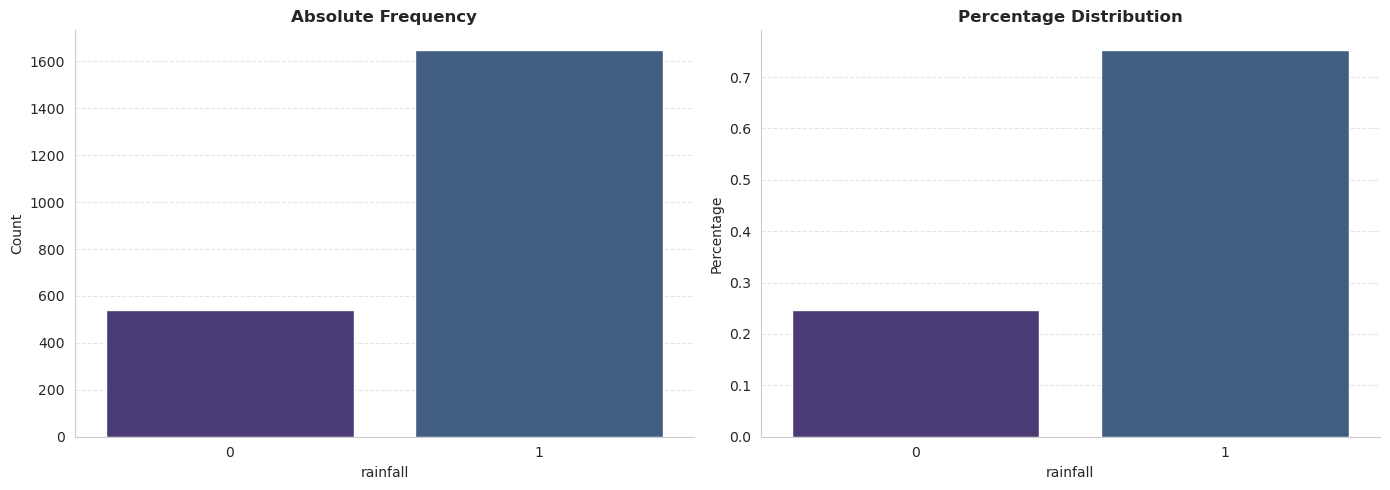

In [94]:
data_overview(train_original, target_feature)

In [95]:
data_overview(test_original, None)

## Data Overview

### General Information

- Number of rows and columns: 730 x 12

- Column names:

['id',
 'day',
 'pressure',
 'maxtemp',
 'temparature',
 'mintemp',
 'dewpoint',
 'humidity',
 'cloud',
 'sunshine',
 'winddirection',
 'windspeed']

### Data Types & Missing Values

,Data Type,Missing Values
id,int64,0
day,int64,0
pressure,float64,0
maxtemp,float64,0
temparature,float64,0
mintemp,float64,0
dewpoint,float64,0
humidity,float64,0
cloud,float64,0
sunshine,float64,0


### Classic head of Data

,id,day,pressure,maxtemp,temparature,mintemp,dewpoint,humidity,cloud,sunshine,winddirection,windspeed
0,2190,1,1019.500000,17.500000,15.800000,12.700000,14.900000,96.000000,99.000000,0.000000,50.000000,24.300000
1,2191,2,1016.500000,17.500000,16.500000,15.800000,15.100000,97.000000,99.000000,0.000000,50.000000,35.300000
2,2192,3,1023.900000,11.200000,10.400000,9.400000,8.900000,86.000000,96.000000,0.000000,40.000000,16.900000
3,2193,4,1022.900000,20.600000,17.300000,15.200000,9.500000,75.000000,45.000000,7.100000,20.000000,50.600000
4,2194,5,1022.200000,16.100000,13.800000,6.400000,4.300000,68.000000,49.000000,9.200000,20.000000,19.400000


### Statistical Summary (describe)

,count,mean,std,min,25%,50%,75%,max
id,730.000000,2554.500000,210.877136,2190.000000,2372.250000,2554.500000,2736.750000,2919.000000
day,730.000000,183.000000,105.438271,1.000000,92.000000,183.000000,274.000000,365.000000
pressure,730.000000,1013.503014,5.505871,1000.000000,1008.725000,1012.700000,1017.600000,1032.200000
maxtemp,730.000000,26.372466,5.672521,7.400000,21.600000,27.800000,31.000000,35.800000
temparature,730.000000,23.963288,5.278098,5.900000,19.825000,25.650000,28.375000,31.800000
mintemp,730.000000,22.110274,5.170744,4.200000,17.825000,23.900000,26.400000,29.100000
dewpoint,730.000000,20.460137,5.391169,-0.000000,16.800000,22.300000,25.000000,26.700000
humidity,730.000000,82.669863,7.818714,39.000000,77.250000,82.000000,89.000000,98.000000
cloud,730.000000,76.360274,17.934121,0.000000,69.000000,83.000000,88.000000,100.000000
sunshine,730.000000,3.664384,3.639272,0.000000,0.325000,2.200000,6.675000,11.800000


<Figure size 640x480 with 0 Axes>

# Quick PreProcessing about some features

In [96]:
# original_data_fix = original_data.copy()
# original_data_fix[target_feature] = original_data_fix[target_feature].map({'yes': 1, 'no': 0})

# # wrong column order
# original_data_fix = original_data_fix[train_original.columns]
# # fix rainfall to integer
# original_data_fix['Rainfall'] = original_data_fix['rainfall'].astype(int)

# original_data_fix.head()

# Optional Point: Concat the data

In [97]:
#Concat train and the original data set
train = train_original.copy()
test = test_original.copy()
train.drop('id', axis=1, inplace=True) #id is not needed for training
test.drop('id', axis=1, inplace=True) #id is not needed for testing

original_data_fix = original_data.copy()
original_data_fix[target_feature] = original_data_fix[target_feature].map({'yes': 1, 'no': 0})

original_data_fix['rainfall'] = original_data_fix['rainfall'].astype(int)
# wrong column order
original_data_fix.columns = original_data_fix.columns.str.strip()
original_data_fix = original_data_fix[train.columns]
#original_data_fix = original_data_fix[train.columns.intersection(original_data_fix.columns)]

original_data_fix.head()
train = pd.concat([train, original_data_fix],ignore_index=True)

In [98]:
train.columns

Index(['day', 'pressure', 'maxtemp', 'temparature', 'mintemp', 'dewpoint',
       'humidity', 'cloud', 'sunshine', 'winddirection', 'windspeed',
       'rainfall'],
      dtype='object')

In [99]:
original_data_fix.columns

Index(['day', 'pressure', 'maxtemp', 'temparature', 'mintemp', 'dewpoint',
       'humidity', 'cloud', 'sunshine', 'winddirection', 'windspeed',
       'rainfall'],
      dtype='object')

In [100]:
train.head(100)

,day,pressure,maxtemp,temparature,mintemp,dewpoint,humidity,cloud,sunshine,winddirection,windspeed,rainfall
0,1,1017.4,21.2,20.6,19.9,19.4,87.0,88.0,1.1,60.0,17.2,1
1,2,1019.5,16.2,16.9,15.8,15.4,95.0,91.0,0.0,50.0,21.9,1
2,3,1024.1,19.4,16.1,14.6,9.3,75.0,47.0,8.3,70.0,18.1,1
3,4,1013.4,18.1,17.8,16.9,16.8,95.0,95.0,0.0,60.0,35.6,1
4,5,1021.8,21.3,18.4,15.2,9.6,52.0,45.0,3.6,40.0,24.8,0
...,...,...,...,...,...,...,...,...,...,...,...,...
95,96,1009.2,28.2,26.7,25.3,23.1,87.0,86.0,0.3,100.0,12.0,0
96,97,1008.6,29.1,26.6,25.4,24.2,93.0,85.0,0.9,220.0,19.0,1
97,98,1011.4,28.2,24.8,22.3,23.7,84.0,85.0,2.4,90.0,14.7,1
98,99,1015.2,25.9,23.4,22.8,21.2,81.0,81.0,3.9,290.0,21.2,1


In [101]:
original_data_fix.head(100)

,day,pressure,maxtemp,temparature,mintemp,dewpoint,humidity,cloud,sunshine,winddirection,windspeed,rainfall
0,1,1025.9,19.9,18.3,16.8,13.1,72,49,9.3,80.0,26.3,1
1,2,1022.0,21.7,18.9,17.2,15.6,81,83,0.6,50.0,15.3,1
2,3,1019.7,20.3,19.3,18.0,18.4,95,91,0.0,40.0,14.2,1
3,4,1018.9,22.3,20.6,19.1,18.8,90,88,1.0,50.0,16.9,1
4,5,1015.9,21.3,20.7,20.2,19.9,95,81,0.0,40.0,13.7,1
...,...,...,...,...,...,...,...,...,...,...,...,...
95,5,1013.3,24.4,22.3,20.7,20.8,91,78,1.0,40.0,14.8,1
96,6,1013.3,26.5,23.1,21.5,21.6,91,83,6.9,70.0,20.0,0
97,7,1013.2,26.9,23.9,22.4,22.3,91,84,1.8,40.0,10.0,0
98,8,1013.3,27.9,25.3,23.2,22.9,87,84,2.5,40.0,9.1,1


In [102]:
# just make sure to concat worked,check if the objecte type is the same
train.iloc[train_original.shape[0]-5:train_original.shape[0]+5].head(10)

,day,pressure,maxtemp,temparature,mintemp,dewpoint,humidity,cloud,sunshine,winddirection,windspeed,rainfall
2185,361,1014.6,23.2,20.6,19.1,19.9,97.0,88.0,0.1,40.0,22.1,1
2186,362,1012.4,17.2,17.3,16.3,15.3,91.0,88.0,0.0,50.0,35.3,1
2187,363,1013.3,19.0,16.3,14.3,12.6,79.0,79.0,5.0,40.0,32.9,1
2188,364,1022.3,16.4,15.2,13.8,14.7,92.0,93.0,0.1,40.0,18.0,1
2189,365,1013.8,21.2,19.1,18.0,18.0,89.0,88.0,1.0,70.0,48.0,1
2190,1,1025.9,19.9,18.3,16.8,13.1,72.0,49.0,9.3,80.0,26.3,1
2191,2,1022.0,21.7,18.9,17.2,15.6,81.0,83.0,0.6,50.0,15.3,1
2192,3,1019.7,20.3,19.3,18.0,18.4,95.0,91.0,0.0,40.0,14.2,1
2193,4,1018.9,22.3,20.6,19.1,18.8,90.0,88.0,1.0,50.0,16.9,1
2194,5,1015.9,21.3,20.7,20.2,19.9,95.0,81.0,0.0,40.0,13.7,1


In [103]:
train.shape

(2556, 12)

# Feature Analyse

## Numeric Feature Attributes

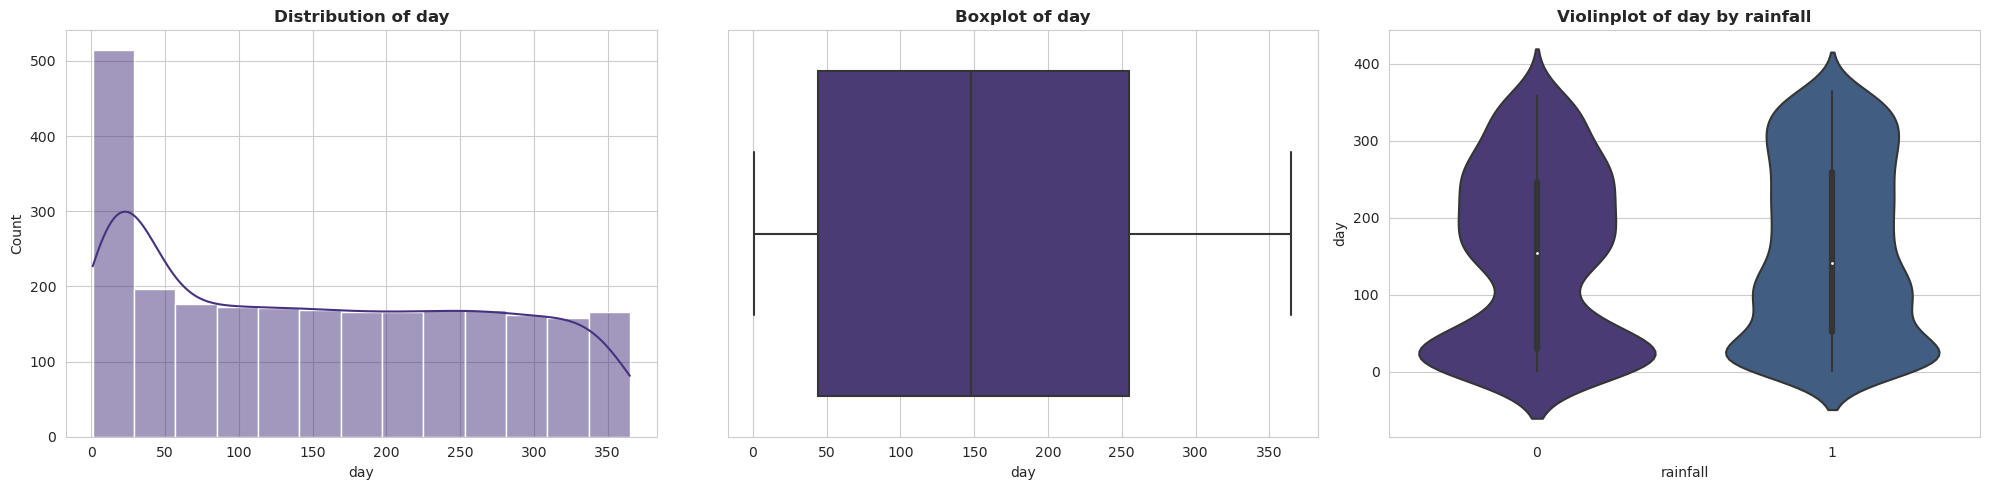

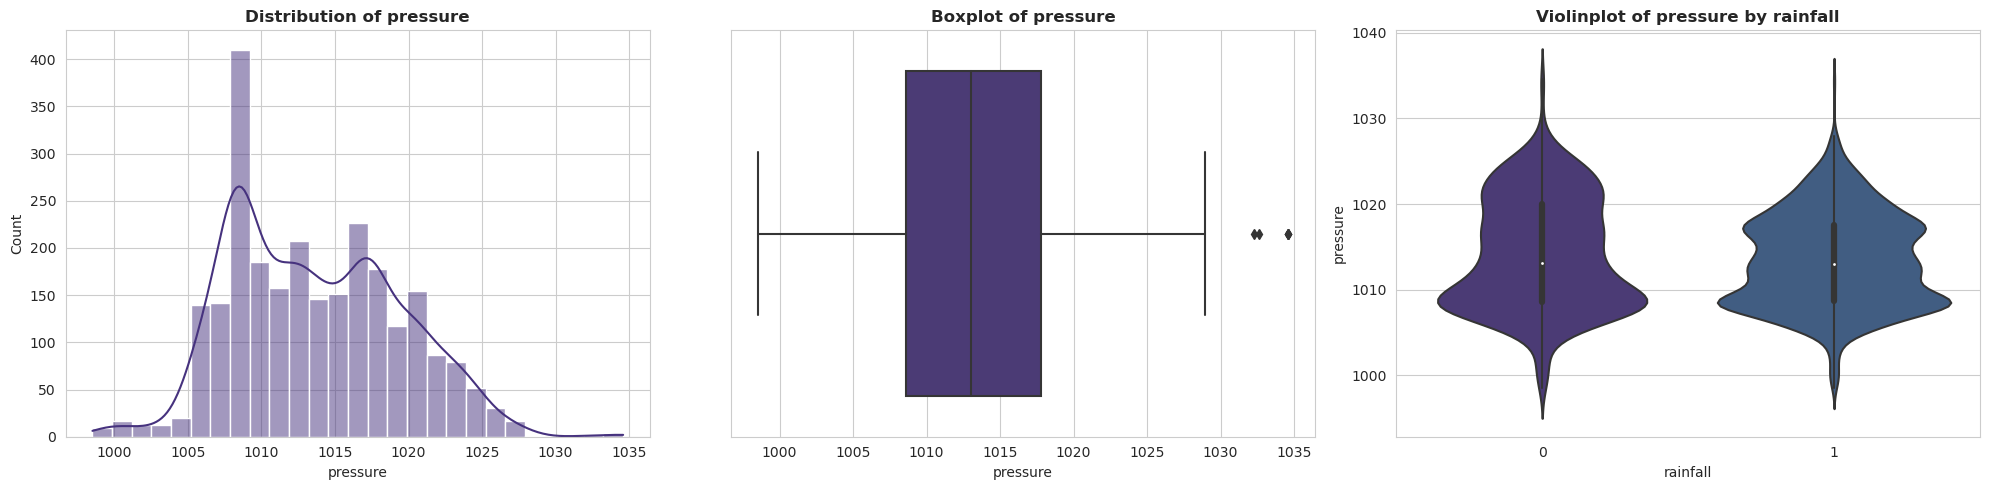

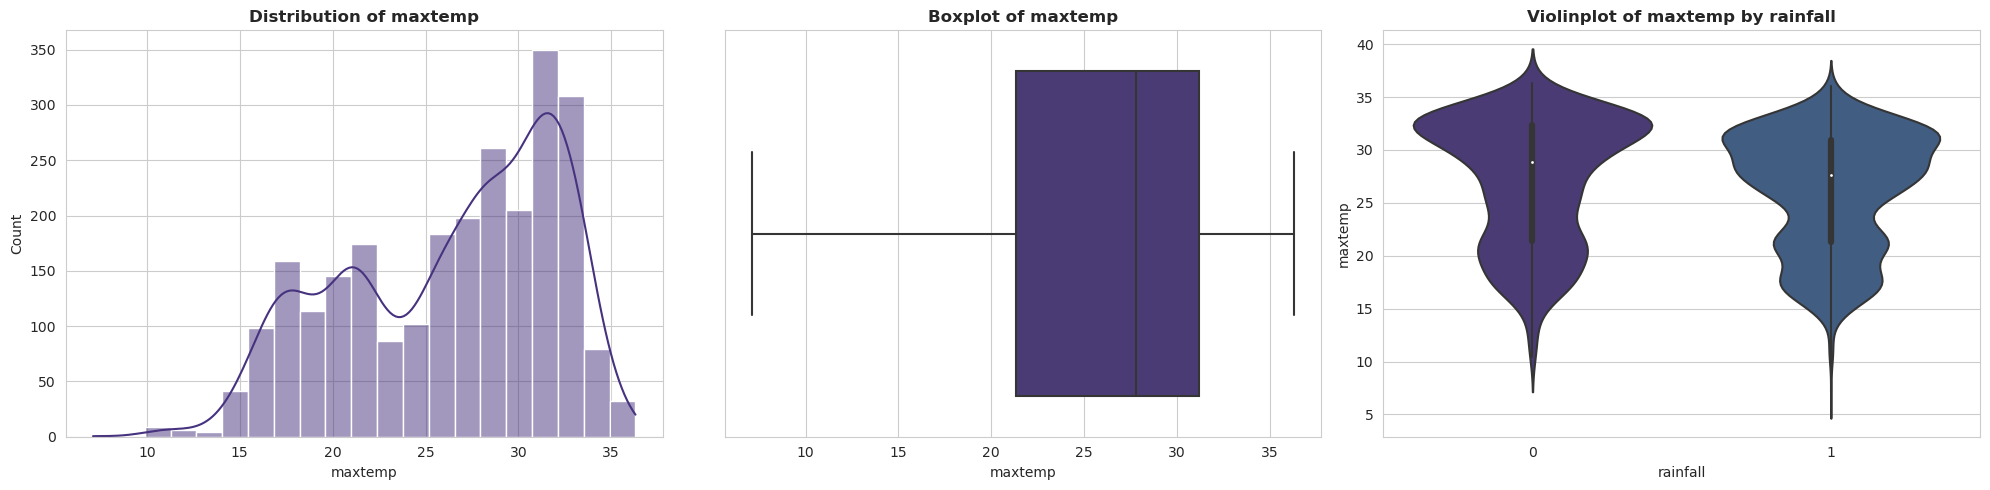

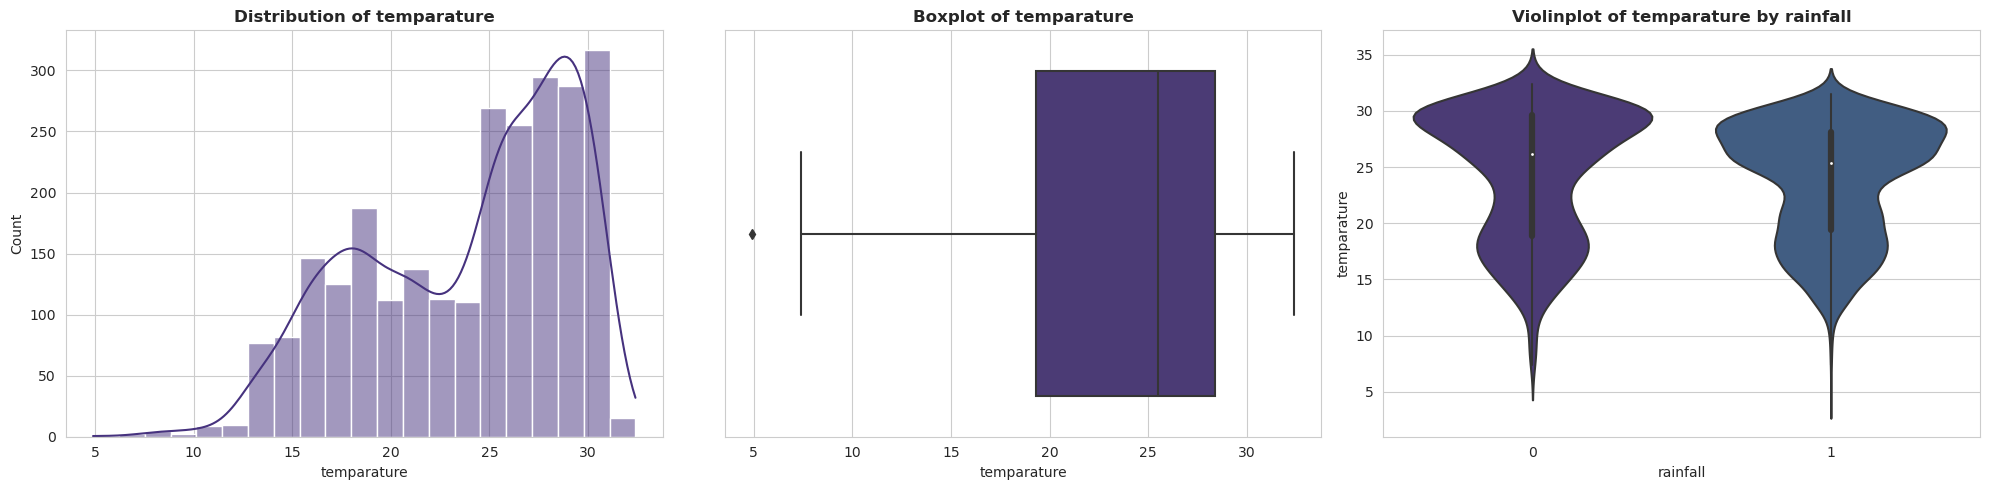

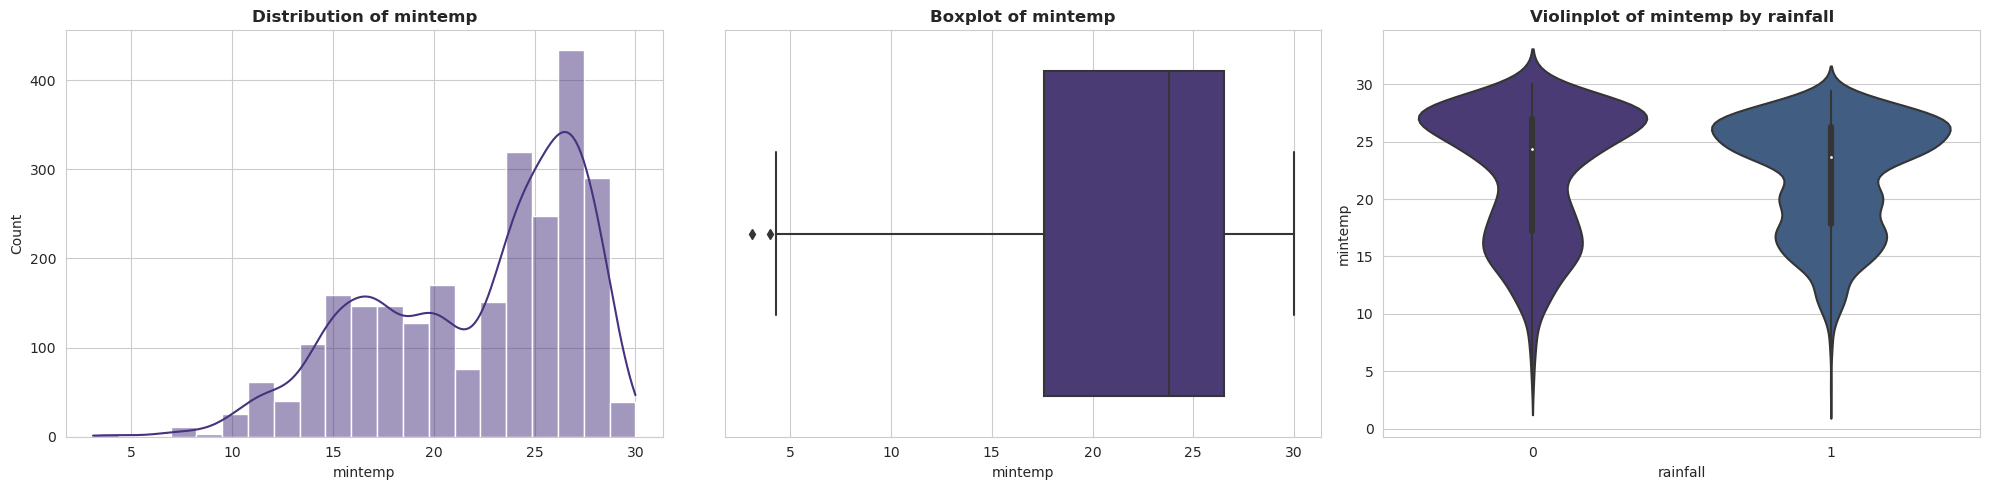

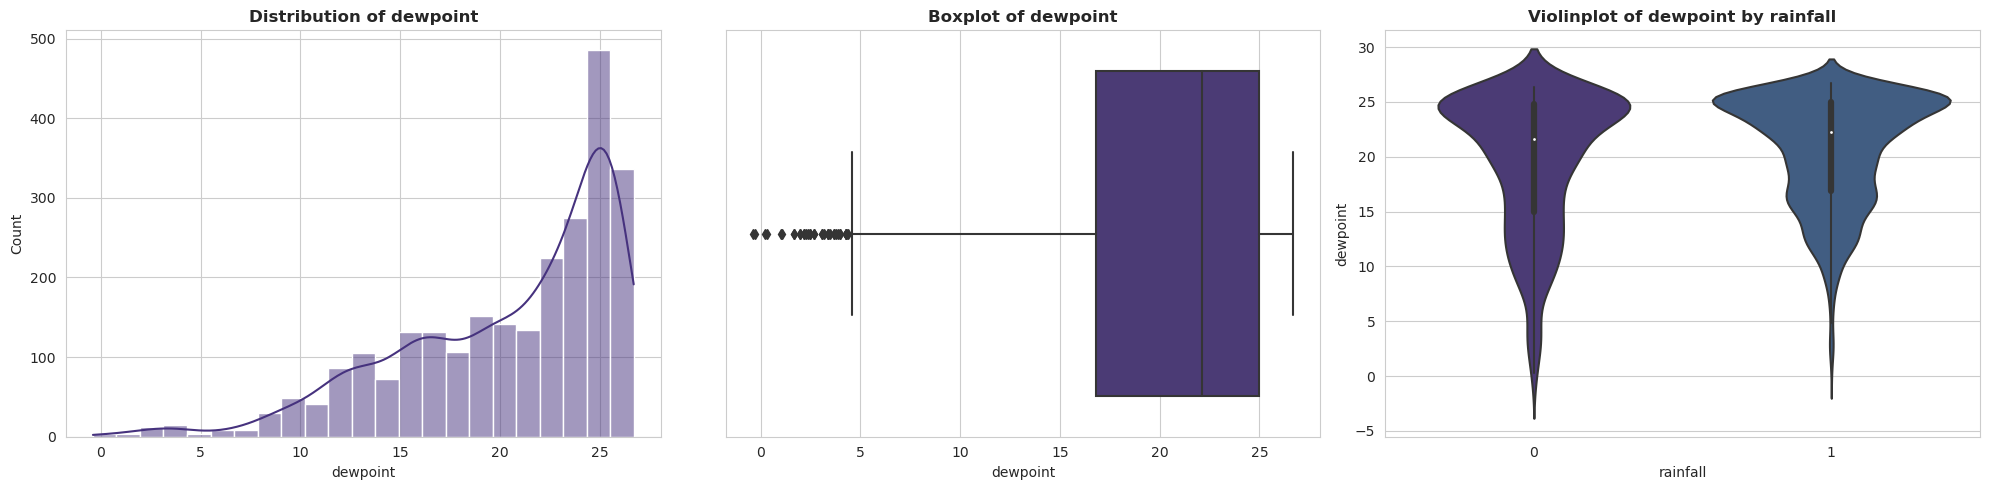

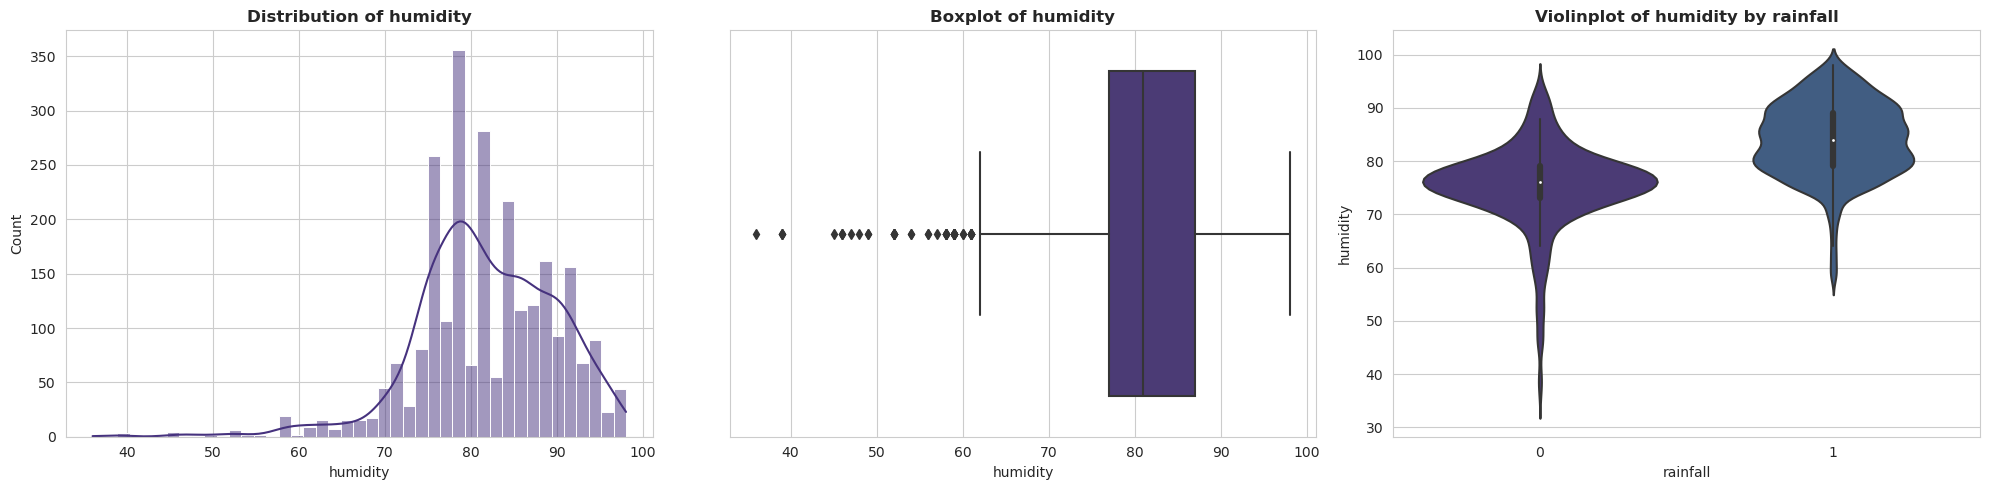

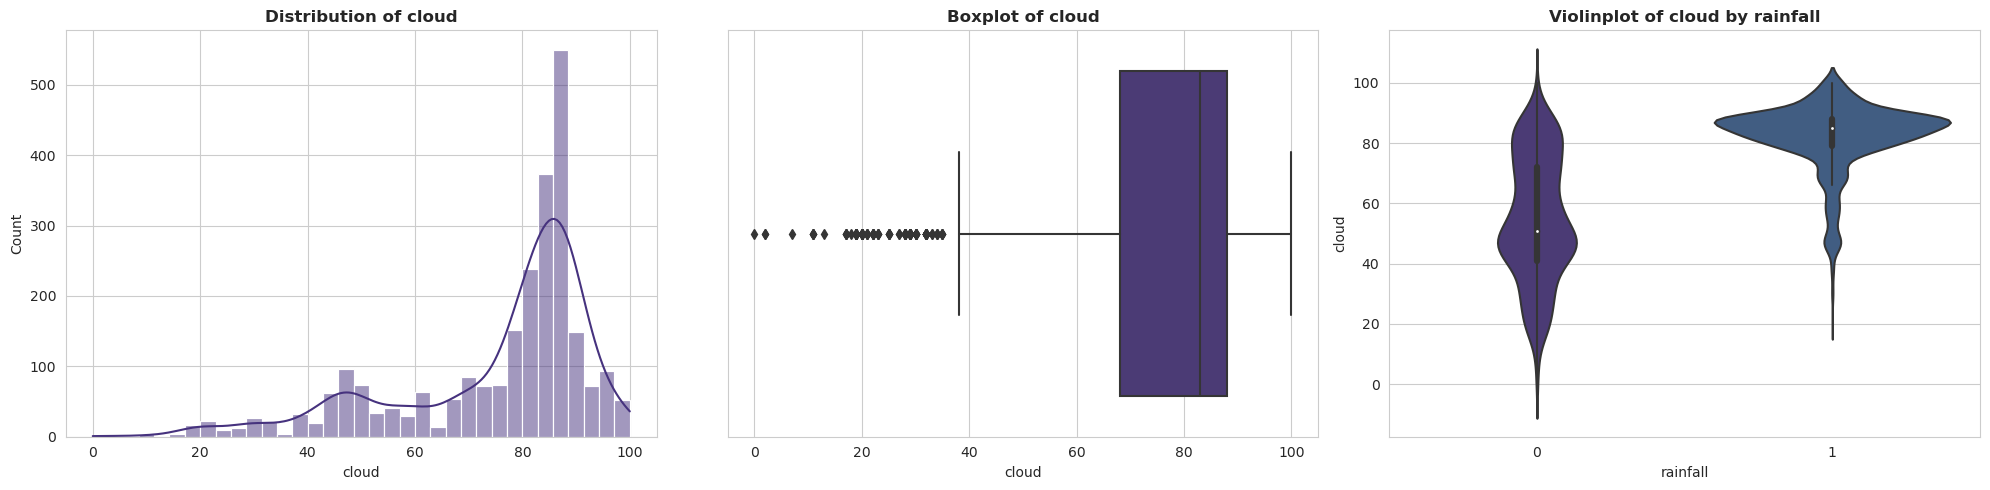

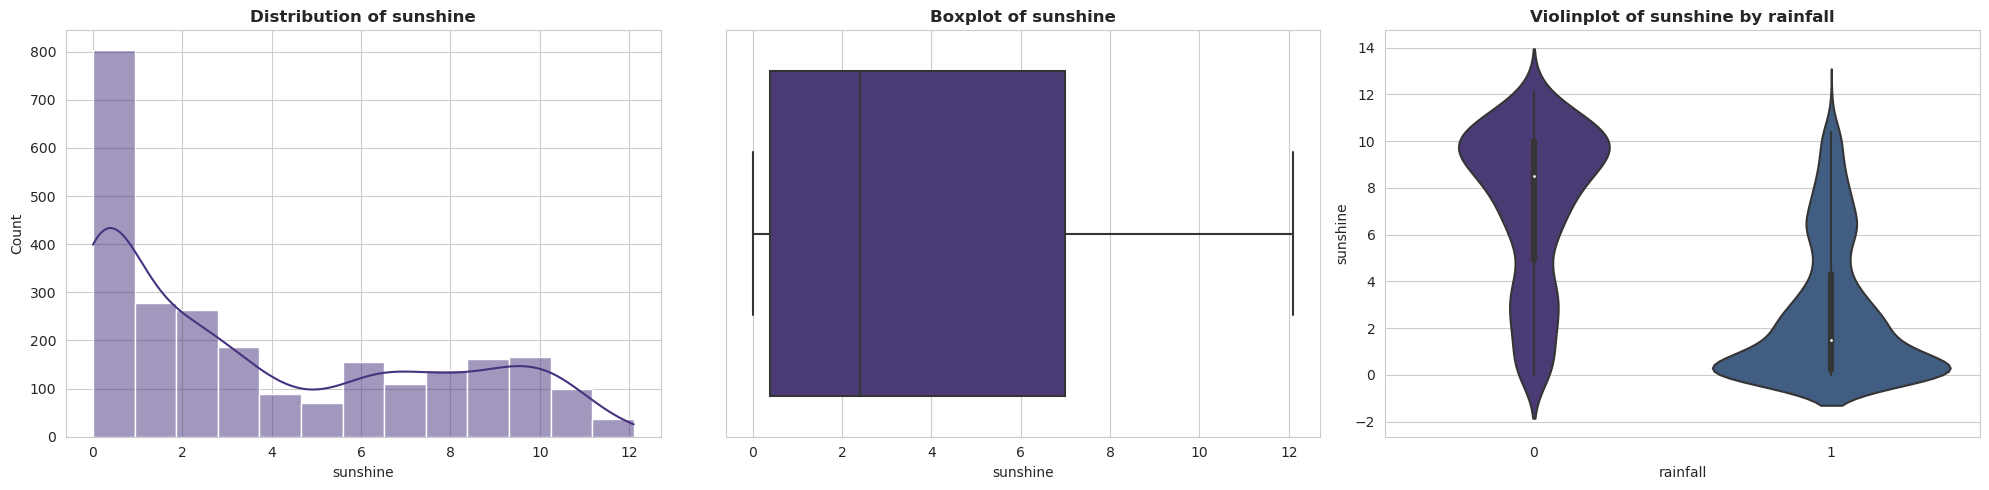

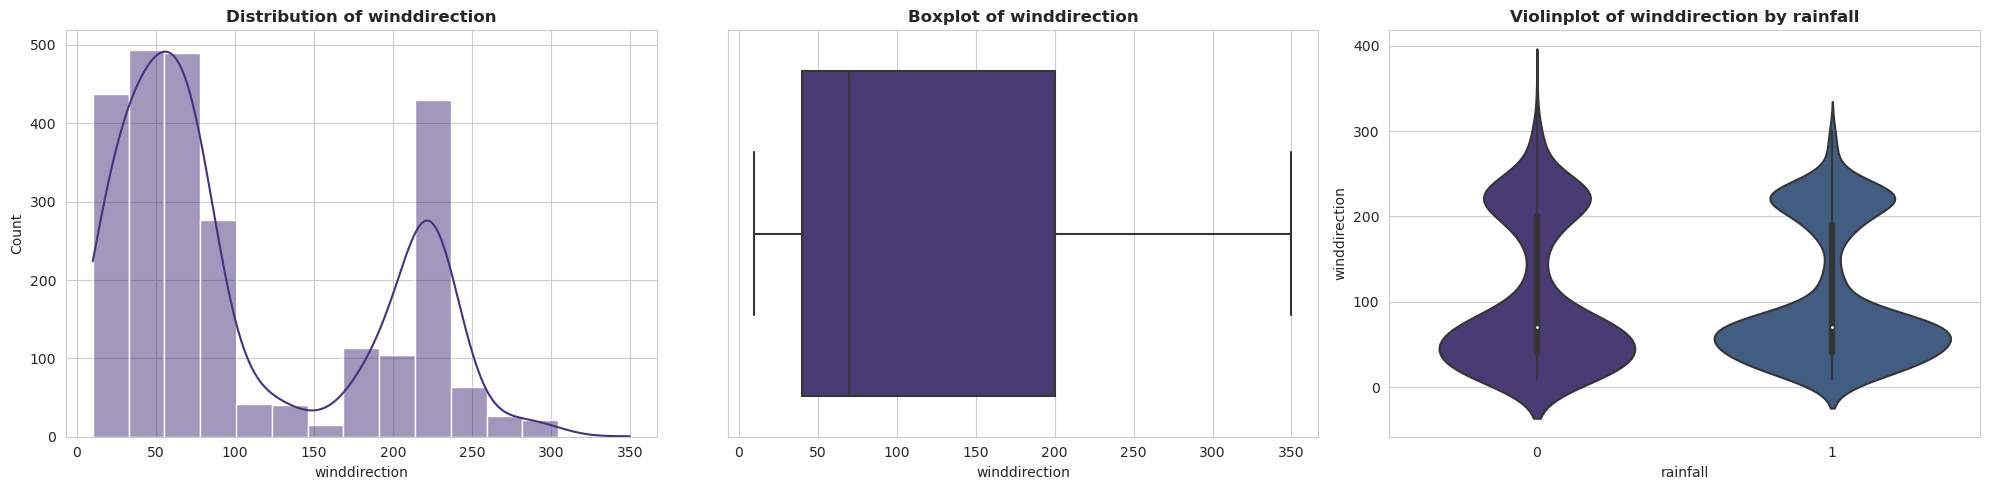

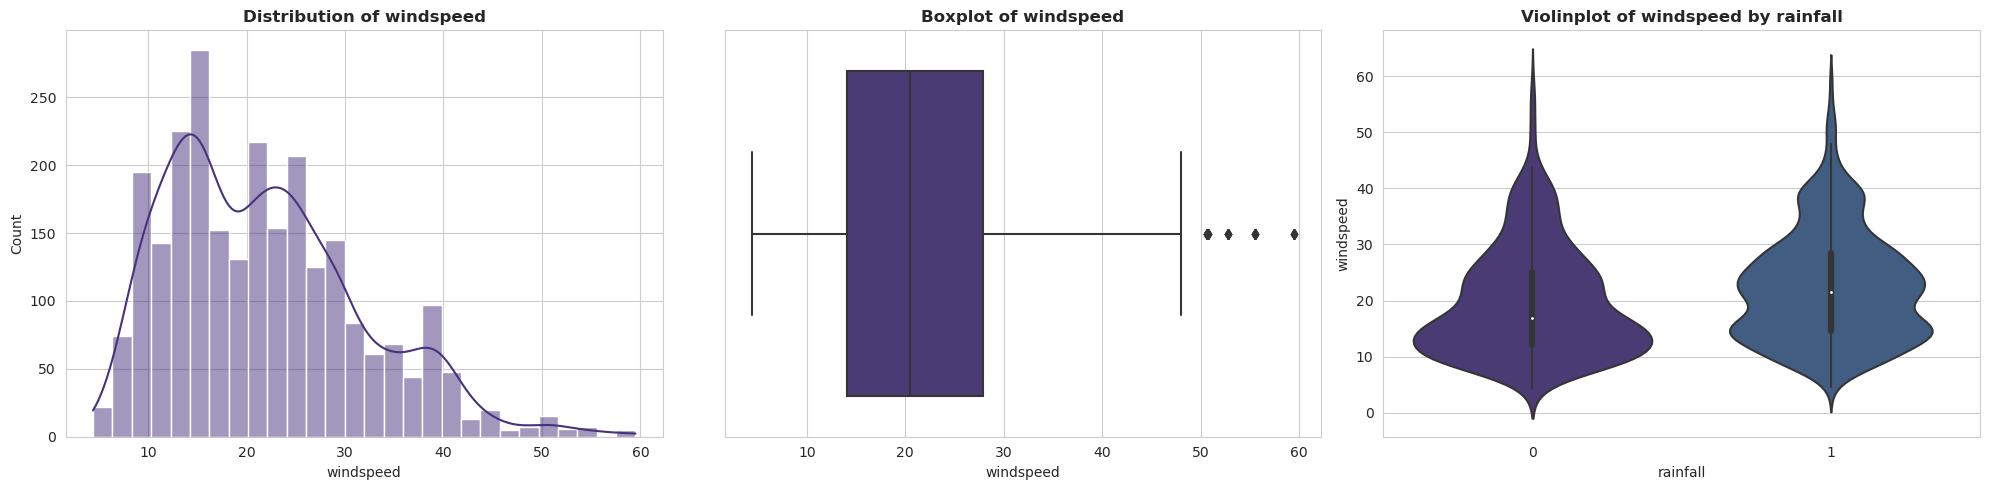

No categorical features found.


In [104]:
def visualize_feature_attributes(df, target=None):
    """ Visualizes numeric and categorical features """

    # Get Numeric & Categorical Features
    numeric_features, categorical_features =get_categorical_numerical_features(df)

    # Numeric Features
    if numeric_features:
        display(Markdown("## Numeric Feature Attributes"))
        for col in numeric_features:
            if col != target:
                plot_numeric_feature(df, col, target)
    else:
        print("No numeric features found.")

    # Categorical Features
    if categorical_features:
        display(Markdown("## Categorical Feature Attributes"))
        for col in categorical_features:
            if col != target:
                if df[col].nunique() > 10:
                    df = reduce_categories(df, col, top_n=15)
                plot_categorical_feature(df, col, target)
    else:
        print("No categorical features found.")


def plot_numeric_feature(df, col, target):
    """ Plots Histogram, Boxplot, and Violinplot for a numeric feature """
    fig, axes = plt.subplots(1, 3, figsize=(20, 5))

    sns.histplot(df[col], ax=axes[0], kde=True)
    axes[0].set_title(f"Distribution of {col}", fontweight="bold")

    sns.boxplot(x=df[col], ax=axes[1])
    axes[1].set_title(f"Boxplot of {col}", fontweight="bold")

    if target and target in df.columns and df[target].nunique() == 2:
        sns.violinplot(x=df[target], y=df[col], ax=axes[2], split=True)
    elif target and target in df.columns:
        sns.violinplot(x=df[target], y=df[col], ax=axes[2], split=False)
    else:
        sns.violinplot(y=df[col], ax=axes[2])

    axes[2].set_title(f"Violinplot of {col} by {target}", fontweight="bold")

    plt.tight_layout()
    plt.show()


def plot_categorical_feature(df, col, target):
    """ Plots Countplot, Hue-Countplot, and Barplot (if target is numeric) for a categorical feature """
    fig, axes = plt.subplots(1, 3, figsize=(20, 5))

    sns.countplot(x=df[col], ax=axes[0])
    axes[0].set_title(f"Countplot of {col}", fontweight="bold")
    axes[0].tick_params(axis='x', rotation=45)

    if target in df.columns:
        sns.countplot(x=df[col], hue=df[target], ax=axes[1])
        axes[1].set_title(f"Countplot of {col} by {target}", fontweight="bold")
        axes[1].tick_params(axis='x', rotation=45)

    if target in df.columns and df[target].dtype in [np.float64, np.int64]:
        sns.barplot(x=df[col], y=df[target], ax=axes[2], estimator=np.mean, errorbar='sd')
        axes[2].set_title(f"Mean {target} by {col}", fontweight="bold")
    else:
        axes[2].remove()  

    plt.tight_layout()
    plt.show()
    

def reduce_categories(df, col, top_n):
    """ Shows only the categories with highes numbers, seldoms are shown with "others" """
    top_categories = df[col].value_counts().nlargest(top_n).index
    df[col] = df[col].apply(lambda x: x if x in top_categories else 'Other')
    return df

def get_categorical_numerical_features(df):
    # Get Numeric & Categorical Features
    numeric_features = df.select_dtypes(include=[np.number]).columns.tolist()
    categorical_features = df.select_dtypes(include=['object', 'category']).columns.tolist()
    return numeric_features, categorical_features

visualize_feature_attributes(train, target=target_feature)

# Correlation Matrix (Numerical values)

<Axes: >

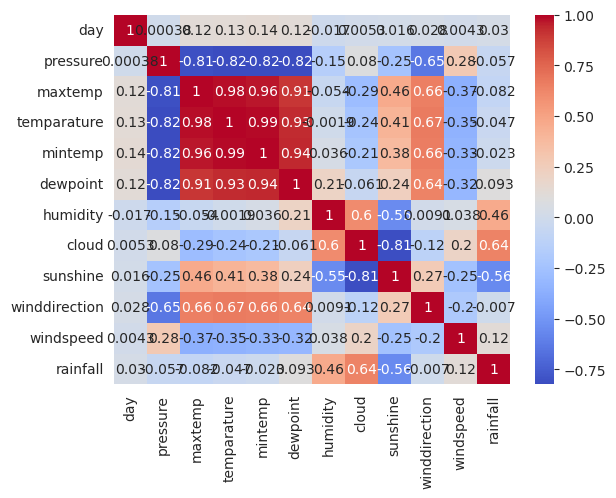

In [105]:
# Get Numeric & Categorical Features
numeric_features, categorical_features = get_categorical_numerical_features(train)
sns.heatmap(train[numeric_features].corr(), annot=True, cmap='coolwarm')

# Analyse categorical features

# Correlation Matrix Categorical Features

# Merge categorical features
I will wait before i will drop features

# Analyze
## Numerical Features
- Missing Values: original_data, windirection and windspeed 2 Values, train_original no missing data, test_original one missing winddirection
- Outliers: there are several outliers, humidity, Cloud,..
- Linear Corr to rainfall, Cloud +0.64 , Sunshine -0.56, humidity +0.46
- None of the features are evenly distributed; all of them have a slight right skew


Off Topic...:
I got curious about air pressure. I pasted the train.describe() values into ChatGPT and asked what kind of region it could be. The response suggested it might be a subtropical or tropical ocean coast, such as Thailand, Vietnam, the Philippines, Brazil, or India?

## Categorical Features
There aren't ones.

# Save CSV Files as Kaggle Datasets

In [106]:
if KAGGLE_ENV:
    train.to_csv('/kaggle/input/s4-e11-train-concat/s4-e11-train-concat.csv', index=False)
else:
    train.to_csv('../kaggle/input/' + '/s4-e11-train-concat/s4-e11-train-concat.csv', index=False)

OSError: Cannot save file into a non-existent directory: '../kaggle/input/s4-e11-train-concat'

In [ ]:
# save test data set
if KAGGLE_ENV:
    test.to_csv('/kaggle/input/s4-e11-test-concat/s4-e11-test-concat.csv', index=False)
else:
    test.to_csv( '../kaggle/input/' + '/s4-e11-test-concat/s4-e11-test-concat.csv', index=False)

In [107]:
train.head()

,day,pressure,maxtemp,temparature,mintemp,dewpoint,humidity,cloud,sunshine,winddirection,windspeed,rainfall
0,1,1017.4,21.2,20.6,19.9,19.4,87.0,88.0,1.1,60.0,17.2,1
1,2,1019.5,16.2,16.9,15.8,15.4,95.0,91.0,0.0,50.0,21.9,1
2,3,1024.1,19.4,16.1,14.6,9.3,75.0,47.0,8.3,70.0,18.1,1
3,4,1013.4,18.1,17.8,16.9,16.8,95.0,95.0,0.0,60.0,35.6,1
4,5,1021.8,21.3,18.4,15.2,9.6,52.0,45.0,3.6,40.0,24.8,0


In [108]:
test.head()

,day,pressure,maxtemp,temparature,mintemp,dewpoint,humidity,cloud,sunshine,winddirection,windspeed
0,1,1019.5,17.5,15.8,12.7,14.9,96.0,99.0,0.0,50.0,24.3
1,2,1016.5,17.5,16.5,15.8,15.1,97.0,99.0,0.0,50.0,35.3
2,3,1023.9,11.2,10.4,9.4,8.9,86.0,96.0,0.0,40.0,16.9
3,4,1022.9,20.6,17.3,15.2,9.5,75.0,45.0,7.1,20.0,50.6
4,5,1022.2,16.1,13.8,6.4,4.3,68.0,49.0,9.2,20.0,19.4
